# SETUPS/LIBS

In [235]:
import pandas as pd
import tqdm
from collections import defaultdict, deque
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime

def mean(lst):
    return sum(lst)/len(lst) if len(lst)>0 else 0

def calculate_bonus_k(date_list, gap_percentiles):
    if len(date_list)<2:
        return 1
    date_diff = (date_list[-1] - date_list[-2]).days
    if date_diff >= gap_percentiles['p99']:
        return 2
    elif date_diff >= gap_percentiles['p95']:
        return 1.6
    elif date_diff >= gap_percentiles['p90']:
        return 1.3
    elif date_diff >= gap_percentiles['p75']:
        return 1.15
    else:
        return 1.0

def calculate_k(elo_dict, gap_percentiles, surf=None):
    if not surf:
        games_played = len(elo_dict) - 1
        break_multiplier=calculate_bonus_k(elo_dict[-1]['Ovr_dates'], gap_percentiles)
        return (800/(games_played + 8)) * break_multiplier
    games_played=0
    curr_elo=1500
    for i in elo_dict:
        if i[surf] != curr_elo:
            games_played+=1
            curr_elo=i[surf]
    break_multiplier=calculate_bonus_k(elo_dict[-1][f"{surf}_dates"], gap_percentiles)
    return min((800/(games_played + 8)) * break_multiplier, 100)

def calc_elo(winner_elo, loser_elo, winner_k, loser_k):
    expected_win = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    new_winner_elo = winner_elo + winner_k * (1 - expected_win)
    new_loser_elo = loser_elo + loser_k * (0 - (1 - expected_win))
    return new_winner_elo, new_loser_elo

def get_player_id(df, name):
    return int(df['winner_id'][df['winner_name']==name].iloc[0])

def get_player_name(df, id):
    return df['winner_name'][df['winner_id']==id].iloc[0]

def gradient(lst):
    n = len(lst)
    if n < 2:
        return 0.0
    x_sum = n * (n - 1) / 2
    x_sq_sum = n * (n - 1) * (2 * n - 1) / 6
    y_sum = np.sum(lst)
    xy_sum = np.sum(np.arange(n) * lst)
    
    denominator = n * x_sq_sum - x_sum * x_sum
    if denominator == 0:
        return 0.0
    return (n * xy_sum - x_sum * y_sum) / denominator

# CLEANING

Combining all data into 1 csv

In [236]:
all_data = pd.DataFrame()
for year in range(1991, 2025):
    file = rf"DATA/atp_matches_{year}.csv"
    year_data = pd.read_csv(file)
    all_data = pd.concat([all_data, year_data], axis=0)

Get date of first game where our players that appear in 2024 grand slam (test set) appear in so we can start from that year

In [237]:
last_grand_slam=all_data.loc[all_data['tourney_name']=="Us Open"]['tourney_id'].iloc[-1]
players = pd.concat([
    all_data[all_data['tourney_id']==last_grand_slam]['loser_id'],
    all_data[all_data['tourney_id']==last_grand_slam]['winner_id']
]).unique().tolist()
mask = all_data['winner_id'].isin(players) | all_data['loser_id'].isin(players)
year=int(all_data[mask]['tourney_date'].iloc[0]/10000)

start from that year to shorten dataset and only learn from "modern tennis"

In [238]:
all_data = pd.DataFrame()
for year in range(year, 2025):
    file = rf"DATA/atp_matches_{year}.csv"
    year_data = pd.read_csv(file)
    all_data = pd.concat([all_data, year_data], axis=0)

Sort by date (newest to oldest) tiebreak on match num

In [239]:
all_data.sort_values(['tourney_date', 'match_num'], inplace=True)


Removing empty data

In [240]:
na_counts=all_data.isna().sum()
all_data_filtered=all_data.dropna(subset=['winner_ht', 'loser_ht', 'winner_age', 'loser_age', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank_points', 'loser_rank_points', 'winner_rank', 'loser_rank', 'surface'])
all_data_filtered.reset_index(drop=True, inplace=True)
all_data_filtered

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2003-339,Adelaide,Hard,32,A,20021230,1,102644,NaN,NaN,...,41.0,29.0,17.0,10.0,4.0,7.0,79.0,494.0,39.0,875.0
1,2003-451,Doha,Hard,32,A,20021230,1,103819,1.0,NaN,...,58.0,39.0,26.0,15.0,5.0,8.0,6.0,2590.0,139.0,274.0
2,2003-891,Chennai,Hard,32,A,20021230,1,103084,1.0,NaN,...,51.0,33.0,22.0,13.0,5.0,9.0,15.0,1725.0,96.0,411.0
3,2003-339,Adelaide,Hard,32,A,20021230,2,101990,NaN,NaN,...,39.0,32.0,12.0,11.0,1.0,2.0,112.0,350.0,137.0,279.0
4,2003-891,Chennai,Hard,32,A,20021230,2,103181,NaN,NaN,...,28.0,18.0,7.0,8.0,2.0,6.0,199.0,167.0,714.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58828,2024-7696,Next Gen Finals,Hard,8,F,20241218,396,210530,5.0,NaN,...,49.0,40.0,9.0,12.0,4.0,6.0,122.0,493.0,20.0,2355.0
58829,2024-7696,Next Gen Finals,Hard,8,F,20241218,397,209950,1.0,NaN,...,33.0,24.0,8.0,9.0,4.0,7.0,20.0,2355.0,48.0,1136.0
58830,2024-7696,Next Gen Finals,Hard,8,F,20241218,398,210530,5.0,NaN,...,55.0,38.0,7.0,13.0,5.0,9.0,122.0,493.0,41.0,1245.0
58831,2024-7696,Next Gen Finals,Hard,8,F,20241218,399,211663,8.0,NaN,...,35.0,19.0,7.0,9.0,10.0,14.0,145.0,409.0,128.0,471.0


getting average break gaps between games

In [241]:
all_surface_gaps = defaultdict(list)
last_surface_match = defaultdict(dict)

# Convert date from int to datetime
def parse_date(date_int):
    date_str = str(date_int)
    return datetime.strptime(date_str, '%Y%m%d')

# Collect all gaps
for row in all_data_filtered.itertuples():
    match_date = parse_date(row.tourney_date)
    surface = row.surface
    
    for player_id in [row.winner_id, row.loser_id]:
        if player_id in last_surface_match[surface]:
            gap = (match_date - last_surface_match[surface][player_id]).days
            all_surface_gaps[surface].append(gap)
        last_surface_match[surface][player_id] = match_date
        
        if player_id in last_surface_match['Ovr']:
            gap = (match_date - last_surface_match['Ovr'][player_id]).days
            all_surface_gaps['Ovr'].append(gap)
        last_surface_match['Ovr'][player_id] = match_date

# Store all percentiles in a dictionary
gap_percentiles = {}
for surface_type in all_surface_gaps:
    gap_percentiles[surface_type] = {
        'p50': np.percentile(all_surface_gaps[surface_type], 50),
        'p75': np.percentile(all_surface_gaps[surface_type], 75),
        'p90': np.percentile(all_surface_gaps[surface_type], 90),
        'p95': np.percentile(all_surface_gaps[surface_type], 95),
        'p99': np.percentile(all_surface_gaps[surface_type], 99)
    }
    print(f"{surface_type} break gap statistics:")
    print(f"Median gap: {gap_percentiles[surface_type]['p50']:.0f} days")
    print(f"75th percentile: {gap_percentiles[surface_type]['p75']:.0f} days")
    print(f"90th percentile: {gap_percentiles[surface_type]['p90']:.0f} days")
    print(f"95th percentile: {gap_percentiles[surface_type]['p95']:.0f} days")
    print(f"99th percentile: {gap_percentiles[surface_type]['p99']:.0f} days\n")

Hard break gap statistics:
Median gap: 6 days
75th percentile: 14 days
90th percentile: 77 days
95th percentile: 147 days
99th percentile: 385 days

Ovr break gap statistics:
Median gap: 6 days
75th percentile: 14 days
90th percentile: 35 days
95th percentile: 77 days
99th percentile: 357 days

Carpet break gap statistics:
Median gap: 0 days
75th percentile: 91 days
90th percentile: 357 days
95th percentile: 364 days
99th percentile: 728 days

Clay break gap statistics:
Median gap: 6 days
75th percentile: 14 days
90th percentile: 140 days
95th percentile: 308 days
99th percentile: 700 days

Grass break gap statistics:
Median gap: 0 days
75th percentile: 14 days
90th percentile: 357 days
95th percentile: 371 days
99th percentile: 1091 days



Creating differences columns

In [242]:
all_data_filtered['ATP_Point_Diff']=all_data_filtered['winner_rank_points']-all_data_filtered['loser_rank_points']
all_data_filtered['Rank_Diff']=all_data_filtered['winner_rank']-all_data_filtered['loser_rank']
all_data_filtered['Height_Diff']=all_data_filtered['winner_ht']-all_data_filtered['loser_ht']
all_data_filtered['Age_Diff']=all_data_filtered['winner_age']-all_data_filtered['loser_age']

C:\Users\leonc\AppData\Local\Temp\ipykernel_12048\2563694532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_filtered['ATP_Point_Diff']=all_data_filtered['winner_rank_points']-all_data_filtered['loser_rank_points']
C:\Users\leonc\AppData\Local\Temp\ipykernel_12048\2563694532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_filtered['Rank_Diff']=all_data_filtered['winner_rank']-all_data_filtered['loser_rank']
C:\Users\leonc\AppData\Local\Temp\ipykernel_12048\2563694532.py:3: SettingW

h2h and h2h on that surface

In [243]:
h2h_surface_dict={surf:{} for surf in all_data_filtered['surface'].unique()}
h2h_dict={}
res_dict=defaultdict(list)

for idx, (w_id, l_id, surface) in enumerate(tqdm.tqdm(zip(all_data_filtered['winner_id'], all_data_filtered['loser_id'], all_data_filtered['surface']), total=len(all_data_filtered))):

    all_data_filtered.at[idx, 'H2H_Diff'] = h2h_dict[w_id][l_id] if w_id in h2h_dict and l_id in h2h_dict[w_id] else 0
    all_data_filtered.at[idx, 'H2H_Surface_Diff'] = h2h_surface_dict[surface][w_id][l_id] if w_id in h2h_surface_dict[surface] and l_id in h2h_surface_dict[surface][w_id] else 0
    all_data_filtered.at[idx, 'N_Games_Diff'] = len(res_dict[w_id])-len(res_dict[l_id])
     
    for g in [3,5,10,25,50,100]:
        all_data_filtered.at[idx, f'Win_Rate_{g}_Diff'] = mean(res_dict[w_id][-g:]) - mean(res_dict[l_id][-g:])

    if w_id in h2h_dict:
        h2h_dict[w_id][l_id] += 1
    else:
        h2h_dict[w_id] = defaultdict(int)
        h2h_dict[w_id][l_id] = 1
    if l_id in h2h_dict:
        h2h_dict[l_id][w_id] -= 1
    else:
        h2h_dict[l_id] = defaultdict(int)
        h2h_dict[l_id][w_id] = -1
    if w_id in h2h_surface_dict[surface]:
        h2h_surface_dict[surface][w_id][l_id] += 1
    else:
        h2h_surface_dict[surface][w_id] = defaultdict(int)
        h2h_surface_dict[surface][w_id][l_id] = 1
    if l_id in h2h_surface_dict[surface]:
        h2h_surface_dict[surface][l_id][w_id] -= 1
    else:
        h2h_surface_dict[surface][l_id] = defaultdict(int)
        h2h_surface_dict[surface][l_id][w_id] = -1
    res_dict[w_id].append(1)
    res_dict[l_id].append(0)



  0%|          | 0/58833 [00:00<?, ?it/s]C:\Users\leonc\AppData\Local\Temp\ipykernel_12048\4037343014.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_filtered.at[idx, 'H2H_Diff'] = h2h_dict[w_id][l_id] if w_id in h2h_dict and l_id in h2h_dict[w_id] else 0
C:\Users\leonc\AppData\Local\Temp\ipykernel_12048\4037343014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_filtered.at[idx, 'H2H_Surface_Diff'] = h2h_surface_dict[surface][w_id][l_id] if w_id in h2h_surface_dict[surface] and l_i

ELOs

In [244]:
elo_dict=defaultdict(lambda: [{'Ovr': 1500, 'Hard': 1500, 'Clay': 1500, 'Grass': 1500, 'Carpet': 1500, 'Ovr_dates': [], 'Hard_dates': [], 'Clay_dates': [], 'Grass_dates': [], 'Carpet_dates': []}])
elo_periods = [5, 10, 20, 35, 50, 100, 250]

for idx, (w_id, l_id, surface, tourney) in enumerate(tqdm.tqdm(zip(all_data_filtered['winner_id'], all_data_filtered['loser_id'], all_data_filtered['surface'], all_data_filtered['tourney_date']), total=len(all_data_filtered))):

    current_w_elo=elo_dict[w_id][-1].copy()
    current_l_elo=elo_dict[l_id][-1].copy()
    elo_w=current_w_elo['Ovr']
    elo_l=current_l_elo['Ovr']
    tourney=parse_date(tourney)


    all_data_filtered.at[idx, 'Elo_Diff'] = elo_w-elo_l
    all_data_filtered.at[idx, 'Elo_Surface_Diff'] = current_w_elo[surface]-current_l_elo[surface]

    for elo in elo_periods:
        available = min(len(elo_dict[w_id]), len(elo_dict[l_id]), elo)
        if available < 2:
            all_data_filtered.at[idx, f'Elo_Grad_{elo}_Diff'] = 0
        else:
            slope_w = gradient([e['Ovr'] for e in elo_dict[w_id][-available:]])
            slope_l = gradient([e['Ovr'] for e in elo_dict[l_id][-available:]])
            all_data_filtered.at[idx, f'Elo_Grad_{elo}_Diff'] = slope_w - slope_l

    new_w_elo, new_l_elo = calc_elo(current_w_elo['Ovr'], current_l_elo['Ovr'], calculate_k(elo_dict[w_id], gap_percentiles['Ovr']), calculate_k(elo_dict[l_id], gap_percentiles['Ovr']))
    new_w_s_elo, new_l_s_elo = calc_elo(current_w_elo[surface], current_l_elo[surface], calculate_k(elo_dict[w_id], gap_percentiles[surface], surf=surface), calculate_k(elo_dict[l_id], gap_percentiles[surface], surf=surface))
    current_w_elo[surface], current_w_elo['Ovr'] = new_w_s_elo, new_w_elo
    current_l_elo[surface], current_l_elo['Ovr'] = new_l_s_elo, new_l_elo
    current_w_elo[f"{surface}_dates"].append(tourney)
    current_l_elo[f"{surface}_dates"].append(tourney)
    current_w_elo['Ovr_dates'].append(tourney)
    current_l_elo['Ovr_dates'].append(tourney)
    elo_dict[w_id].append(current_w_elo)
    elo_dict[l_id].append(current_l_elo)


  0%|          | 0/58833 [00:00<?, ?it/s]C:\Users\leonc\AppData\Local\Temp\ipykernel_12048\2177084917.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_filtered.at[idx, 'Elo_Diff'] = elo_w-elo_l
C:\Users\leonc\AppData\Local\Temp\ipykernel_12048\2177084917.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_filtered.at[idx, 'Elo_Surface_Diff'] = current_w_elo[surface]-current_l_elo[surface]
C:\Users\leonc\AppData\Local\Temp\ipykernel_12048\2177084917.py:19: SettingWithCopyWarning: 
A va

Last M Matches Data

In [245]:
for m in [3,5,10,20,50,100,200,300,2000]:
    last_m_matches= defaultdict(lambda: defaultdict(lambda: deque(maxlen=m)))
    p_ace_m=[]
    p_df_m=[]
    p_1stIn_m=[]
    p_1stWon_m=[]
    p_2ndWon_m=[]
    p_bpSaved_m=[]  
    p_bpConv_m=[]
    p_rpw_m=[]
    p_acedAgainst_m = []
    p_totalPtsWon_m = []
    p_dominanceRatio_m = []
    for row in tqdm.tqdm(all_data_filtered.itertuples(index=False), total=len(all_data_filtered)):
        w_id,l_id=row.winner_id, row.loser_id
        w_ace,l_ace=row.w_ace, row.l_ace
        w_df,l_df=row.w_df, row.l_df
        w_svpt,l_svpt=row.w_svpt, row.l_svpt
        w_1stIn,l_1stIn=row.w_1stIn, row.l_1stIn
        w_1stWon,l_1stWon=row.w_1stWon, row.l_1stWon
        w_2ndWon,l_2ndWon=row.w_2ndWon, row.l_2ndWon
        w_svgms,l_svgms=row.w_SvGms, row.l_SvGms
        w_bpSaved,l_bpSaved=row.w_bpSaved, row.l_bpSaved
        w_bpFaced,l_bpFaced=row.w_bpFaced, row.l_bpFaced

        #update from past data for current match
        p_ace_m.append(mean(last_m_matches[w_id]["p_ace"])-mean(last_m_matches[l_id]["p_ace"]))
        p_df_m.append(mean(last_m_matches[w_id]["p_df"])-mean(last_m_matches[l_id]["p_df"]))
        p_1stIn_m.append(mean(last_m_matches[w_id]["p_1stIn"])-mean(last_m_matches[l_id]["p_1stIn"]))
        p_1stWon_m.append(mean(last_m_matches[w_id]["p_1stWon"])-mean(last_m_matches[l_id]["p_1stWon"]))
        p_2ndWon_m.append(mean(last_m_matches[w_id]["p_2ndWon"])-mean(last_m_matches[l_id]["p_2ndWon"]))
        p_bpSaved_m.append(mean(last_m_matches[w_id]["p_bpSaved"])-mean(last_m_matches[l_id]["p_bpSaved"]))
        p_bpConv_m.append(mean(last_m_matches[w_id]["p_bpConv"])-mean(last_m_matches[l_id]["p_bpConv"]))
        p_rpw_m.append(mean(last_m_matches[w_id]["p_rpw"])-mean(last_m_matches[l_id]["p_rpw"]))
        p_acedAgainst_m.append(mean(last_m_matches[w_id]["p_acedAgainst"])-mean(last_m_matches[l_id]["p_acedAgainst"]))
        p_totalPtsWon_m.append(mean(last_m_matches[w_id]["p_totalPtsWon"]) - mean(last_m_matches[l_id]["p_totalPtsWon"]))
        p_dominanceRatio_m.append(mean(last_m_matches[w_id]["p_dominanceRatio"]) - mean(last_m_matches[l_id]["p_dominanceRatio"]))


        #add current match data to history
        if (w_svpt != 0) and (w_svpt != w_1stIn):
            last_m_matches[w_id]["p_ace"].append(w_ace/w_svpt)
            last_m_matches[w_id]["p_df"].append(w_df/w_svpt)
            last_m_matches[w_id]["p_1stIn"].append(w_1stIn/w_svpt)
            last_m_matches[w_id]["p_2ndWon"].append(w_2ndWon/w_svpt)
            last_m_matches[l_id]["p_acedAgainst"].append(w_ace/w_svpt)
            
        if (l_svpt != 0) and (l_svpt != l_1stIn):
            last_m_matches[l_id]["p_ace"].append(l_ace/l_svpt)
            last_m_matches[l_id]["p_df"].append(l_df/l_svpt)
            last_m_matches[l_id]["p_1stIn"].append(l_1stIn/l_svpt)
            last_m_matches[l_id]["p_2ndWon"].append(l_2ndWon/l_svpt)
            last_m_matches[w_id]["p_acedAgainst"].append(l_ace/l_svpt)

        # RPW calculations (CORRECTED)
        if l_svpt != 0:
            w_rpw = (l_svpt - (l_1stWon + l_2ndWon)) / l_svpt
            last_m_matches[w_id]["p_rpw"].append(w_rpw)
            
        if w_svpt != 0:
            l_rpw = (w_svpt - (w_1stWon + w_2ndWon)) / w_svpt
            last_m_matches[l_id]["p_rpw"].append(l_rpw)

        if (w_svpt + l_svpt) != 0:
            w_total_points_won = (w_1stWon + w_2ndWon) + (l_svpt - (l_1stWon + l_2ndWon))
            w_tpw = w_total_points_won / (w_svpt + l_svpt)
            last_m_matches[w_id]["p_totalPtsWon"].append(w_tpw)
    
            l_total_points_won = (l_1stWon + l_2ndWon) + (w_svpt - (w_1stWon + w_2ndWon))
            l_tpw = l_total_points_won / (w_svpt + l_svpt)
            last_m_matches[l_id]["p_totalPtsWon"].append(l_tpw)

        if w_svpt != 0 and l_svpt != 0:
            w_serve_lost_pct = 1 - ((w_1stWon + w_2ndWon) / w_svpt)
            if w_serve_lost_pct > 0:  
                w_dominance = w_rpw / w_serve_lost_pct
                last_m_matches[w_id]["p_dominanceRatio"].append(w_dominance)
            
            l_serve_lost_pct = 1 - ((l_1stWon + l_2ndWon) / l_svpt)
            if l_serve_lost_pct > 0:
                l_dominance = l_rpw / l_serve_lost_pct
                last_m_matches[l_id]["p_dominanceRatio"].append(l_dominance)
        
        if w_1stIn!=0:
            last_m_matches[w_id]["p_1stWon"].append(w_1stWon/w_1stIn)
        if l_1stIn!=0:
            last_m_matches[l_id]["p_1stWon"].append(l_1stWon/l_1stIn)

        if w_bpFaced != 0:
            last_m_matches[w_id]["p_bpSaved"].append(w_bpSaved/w_bpFaced)
            l_bp_converted = (w_bpFaced - w_bpSaved) / w_bpFaced 
            last_m_matches[l_id]["p_bpConv"].append(l_bp_converted)
            
        if l_bpFaced != 0:
            last_m_matches[l_id]["p_bpSaved"].append(l_bpSaved/l_bpFaced)
            w_bp_converted = (l_bpFaced - l_bpSaved) / l_bpFaced 
            last_m_matches[w_id]["p_bpConv"].append(w_bp_converted)
    
    all_data_filtered[f'p_ace_diff_last_{m}']=p_ace_m
    all_data_filtered[f'p_df_diff_last_{m}']=p_df_m
    all_data_filtered[f'p_1stIn_diff_last_{m}']=p_1stIn_m
    all_data_filtered[f'p_1stWon_diff_last_{m}']=p_1stWon_m
    all_data_filtered[f'p_2ndWon_diff_last_{m}']=p_2ndWon_m
    all_data_filtered[f'p_bpSaved_diff_last_{m}']=p_bpSaved_m
    all_data_filtered[f'p_bpConv_diff_last_{m}']=p_bpConv_m
    all_data_filtered[f'p_rpw_diff_last_{m}']=p_rpw_m
    all_data_filtered[f'p_acedAgainst_diff_last_{m}'] = p_acedAgainst_m
    all_data_filtered[f'p_totalPtsWon_diff_last_{m}'] = p_totalPtsWon_m
    all_data_filtered[f'p_dominanceRatio_diff_last_{m}'] = p_dominanceRatio_m

100%|██████████| 58833/58833 [00:02<00:00, 23885.25it/s]
C:\Users\leonc\AppData\Local\Temp\ipykernel_12048\2765281495.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_filtered[f'p_ace_diff_last_{m}']=p_ace_m
C:\Users\leonc\AppData\Local\Temp\ipykernel_12048\2765281495.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_filtered[f'p_df_diff_last_{m}']=p_df_m
C:\Users\leonc\AppData\Local\Temp\ipykernel_12048\2765281495.py:101: SettingWithCopyWarning: 
A value is trying to be set on a c

Finalise df, and duplicate each row, flipping relevant fields for a balanced dataset. Get last grand slam starting index to split train/test. Create order df to aligne future betting df to test df.

In [246]:
first_g_slam=all_data_filtered[all_data_filtered['tourney_id']==last_grand_slam].index[0] #getting first index of the last grand slam in the original all_data dataframe

In [247]:
all_data_filtered[['winner_rank', 'loser_rank']].iloc[first_g_slam:first_g_slam+126].to_csv("Final/order.csv", index=False)

In [248]:
final_data=all_data_filtered.drop(columns=['tourney_id', 'tourney_name', 'surface', 'tourney_level', 'tourney_date', 'match_num', 'round', 'minutes', 'winner_seed', 'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'winner_rank_points', 'winner_rank',
'loser_seed', 'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'loser_rank_points', 'loser_rank', 'score',
'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_id', 'loser_id'])

In [249]:
# Start with final_data
train_df = final_data.copy()
train_df['result']=1

# Identify diff columns
diff_columns = [col for col in train_df.columns if 'diff' in col.lower()]+['result']

np.random.seed(100)  # added random seed fix for reproducability
train_df[diff_columns] = train_df[diff_columns].apply(lambda row: row * -1 if np.random.rand() < 0.5 else row, axis=1)
train_df.loc[train_df['result']==-1, 'result']=0

# PLOTS

In [250]:
final_data

,draw_size,best_of,ATP_Point_Diff,Rank_Diff,Height_Diff,Age_Diff,H2H_Diff,H2H_Surface_Diff,N_Games_Diff,Win_Rate_3_Diff,...,p_df_diff_last_2000,p_1stIn_diff_last_2000,p_1stWon_diff_last_2000,p_2ndWon_diff_last_2000,p_bpSaved_diff_last_2000,p_bpConv_diff_last_2000,p_rpw_diff_last_2000,p_acedAgainst_diff_last_2000,p_totalPtsWon_diff_last_2000,p_dominanceRatio_diff_last_2000
0,32,3,-381.0,40.0,-2.0,-3.9,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,32,3,2316.0,-133.0,7.0,-4.6,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,32,3,1314.0,-81.0,-18.0,-6.8,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,32,3,71.0,-25.0,18.0,2.5,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,32,3,151.0,-515.0,-3.0,5.4,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58828,8,5,-1862.0,102.0,-5.0,-1.5,-1.0,-1.0,-96.0,0.000000,...,-0.018114,0.066228,-0.134114,-0.033771,0.027186,0.107042,-0.009082,0.019052,-0.037138,-0.252824
58829,8,5,1219.0,-28.0,-8.0,1.3,0.0,0.0,58.0,0.000000,...,0.000546,0.012693,0.018620,0.002048,0.008486,-0.078008,0.006741,-0.010009,0.011868,0.055402
58830,8,5,-752.0,81.0,-13.0,-1.3,0.0,0.0,-68.0,-0.333333,...,-0.004932,0.001267,-0.059101,-0.008200,0.050500,0.024327,-0.017514,0.006388,-0.029534,-0.203707
58831,8,5,-62.0,17.0,7.0,-2.2,0.0,0.0,-42.0,0.333333,...,-0.015509,0.050025,0.004857,-0.007956,-0.051794,-0.022708,0.008162,-0.029988,0.020488,0.141528


In [251]:
train_df[:first_g_slam].to_csv("Final/train.csv", index=False)
train_df[first_g_slam:].to_csv("Final/test.csv", index=False)

In [252]:
print(len(train_df.columns))
train_df.columns

124


Index(['draw_size', 'best_of', 'ATP_Point_Diff', 'Rank_Diff', 'Height_Diff',
       'Age_Diff', 'H2H_Diff', 'H2H_Surface_Diff', 'N_Games_Diff',
       'Win_Rate_3_Diff',
       ...
       'p_1stIn_diff_last_2000', 'p_1stWon_diff_last_2000',
       'p_2ndWon_diff_last_2000', 'p_bpSaved_diff_last_2000',
       'p_bpConv_diff_last_2000', 'p_rpw_diff_last_2000',
       'p_acedAgainst_diff_last_2000', 'p_totalPtsWon_diff_last_2000',
       'p_dominanceRatio_diff_last_2000', 'result'],
      dtype='object', length=124)

In [253]:
train_df['result'].value_counts()

result
1.0    29491
0.0    29342
Name: count, dtype: int64

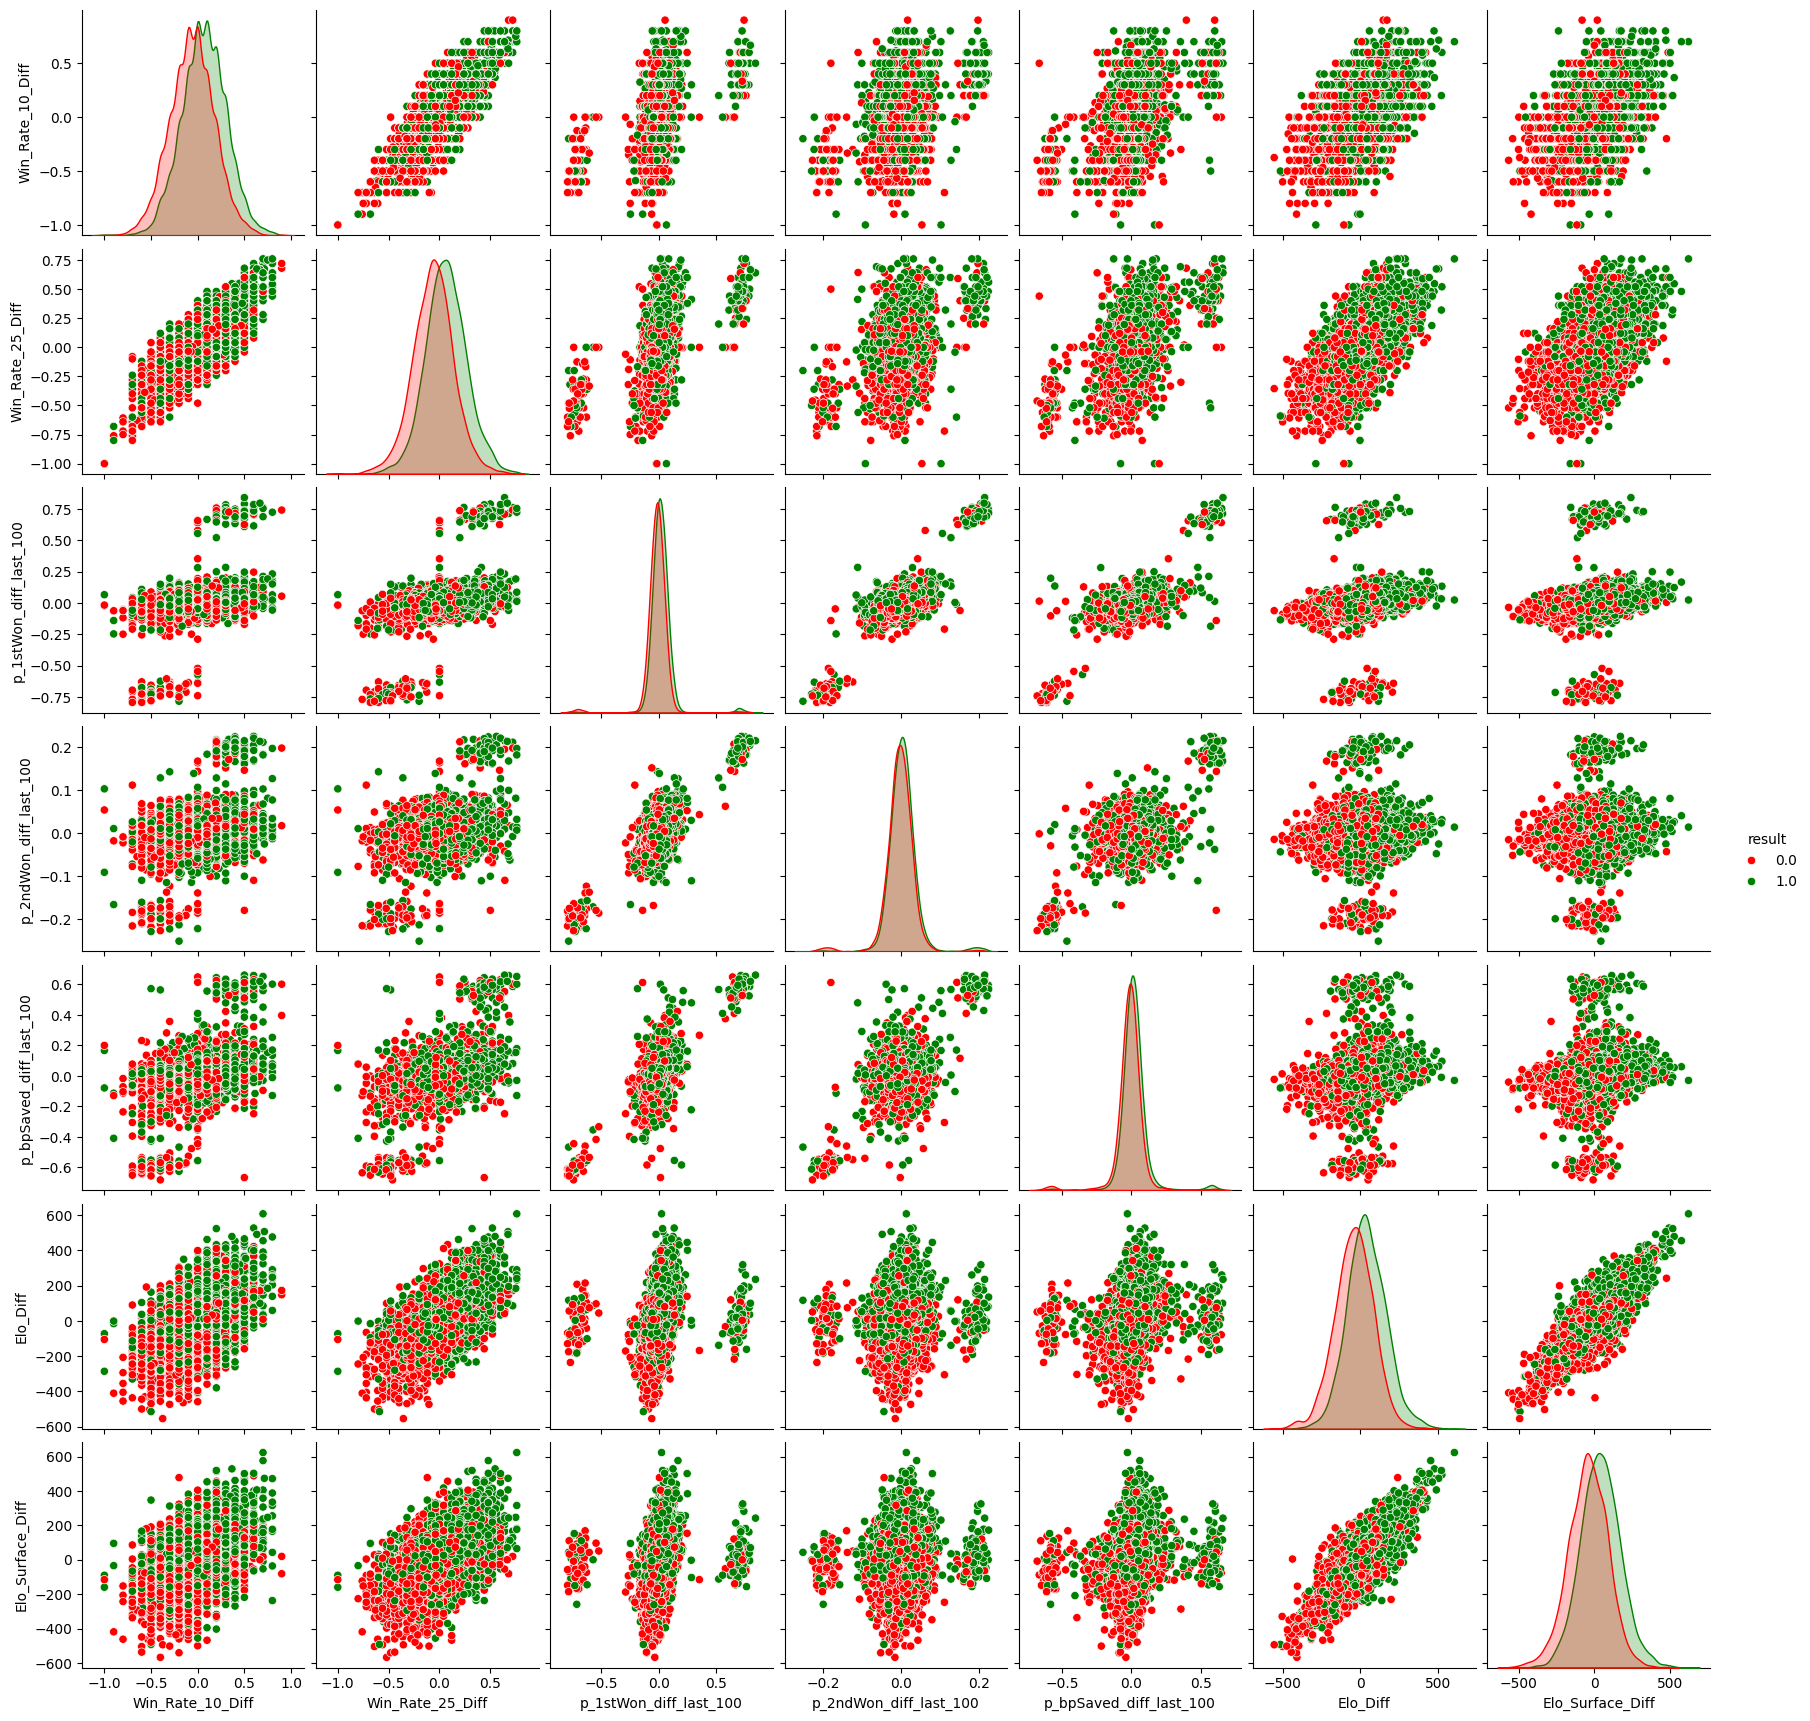

In [254]:
chosen_cols = [  
    'Win_Rate_10_Diff',
    'Win_Rate_25_Diff',
    'p_1stWon_diff_last_100',
    'p_2ndWon_diff_last_100',
    'p_bpSaved_diff_last_100',
    'Elo_Diff',
    'Elo_Surface_Diff', 
    'result'
]

sns.pairplot(train_df[chosen_cols].iloc[50000:60000], hue='result',
             palette={0: 'red', 1: 'green'},
             diag_kind='kde')

ELO Plots

In [255]:

def plot_elo_evolution(elo_list, player_name="Player"):
    """
    Plot ELO evolution over games
    
    Args:
        elo_list: List of ELO values over time
        player_name: Name for the plot title
    """
    games = list(range(len(elo_list)))
    
    plt.figure(figsize=(10, 6))
    plt.plot(games, elo_list, marker='o', markersize=4, linewidth=2)
    
    plt.xlabel('Number of Games', fontsize=12)
    plt.ylabel('ELO Rating', fontsize=12)
    plt.title(f'ELO Evolution - {player_name}', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Add horizontal line at starting ELO for reference
    plt.axhline(y=1500, color='r', linestyle='--', alpha=0.5, label='Starting ELO')
    
    # Add some stats
    plt.text(0.02, 0.98, f'Current ELO: {elo_list[-1]:.0f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage with your data:
# plot_elo_evolution(elo_dict['player_id'], 'Player Name')

# Or to plot multiple players on same graph:
def plot_multiple_elos(elo_dict, highlight_ids=None):
    """
    Plot all players' ELO evolution with option to highlight specific ones
    
    Args:
        elo_dict: Dictionary with player_id as key and ELO list as value
        highlight_ids: List of player IDs to highlight (optional)
    """
    plt.figure(figsize=(12, 7))
    
    if highlight_ids is None:
        highlight_ids = []
    
    # Plot all players in gray/faded first
    for player_id in elo_dict:
        if player_id not in highlight_ids:
            games = list(range(len(elo_dict[player_id])))
            plt.plot(games, [i['Ovr'] for i in elo_dict[player_id]], color='gray', alpha=0.2, 
                    linewidth=0.5)
    
    # Then plot highlighted players with colors and labels
    colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink', 'olive', 'cyan']
    for i, player_id in enumerate(highlight_ids):
        if player_id in elo_dict:
            games = list(range(len(elo_dict[player_id])))
            color = colors[i % len(colors)]
            plt.plot(games, [i['Ovr'] for i in elo_dict[player_id]], marker='o', markersize=3, 
                    linewidth=2.5, label=f'Player {player_id}', alpha=0.9, color=color)
    
    plt.xlabel('Number of Games', fontsize=12)
    plt.ylabel('ELO Rating', fontsize=12)
    plt.title('ELO Evolution - All Players', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=1500, color='r', linestyle='--', alpha=0.5, label='Starting ELO')
    
    if highlight_ids:
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_surface_elo_evolution(elo_dict, player_id):
    """
    Plot ELO evolution for a specific player across different surfaces
    
    Args:
        elo_dict: Dict of type {player_id: [list of dicts with 'Ovr', 'Hard', 'Clay', 'Grass', 'Carpet']}
        player_id: The player ID to plot
    """
    plt.figure(figsize=(12, 7))
    
    colors = {
        'Ovr': 'black', 
        'Hard': 'blue', 
        'Clay': 'orange', 
        'Grass': 'green', 
        'Carpet': 'purple'
    }
    
    if player_id not in elo_dict:
        print(f"Player {player_id} not found")
        return
    
    elo_history = elo_dict[player_id]
    
    # Extract ELO values for each surface
    surfaces = ['Ovr', 'Hard', 'Clay', 'Grass', 'Carpet']
    
    for surface in surfaces:
        # Get all ELO values for this surface from the list of dicts
        elo_values = [game_dict.get(surface) for game_dict in elo_history 
                      if surface in game_dict]
        
        if elo_values:
            games = list(range(len(elo_values)))
            plt.plot(games, elo_values, marker='o', markersize=4, 
                    linewidth=2, label=f'{surface} (Current: {elo_values[-1]:.0f})', 
                    alpha=0.8, color=colors[surface])
    
    plt.xlabel('Number of Games on Surface', fontsize=12)
    plt.ylabel('ELO Rating', fontsize=12)
    plt.title(f'ELO Evolution by Surface - Player {player_id}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=1500, color='r', linestyle='--', alpha=0.5, label='Starting ELO')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


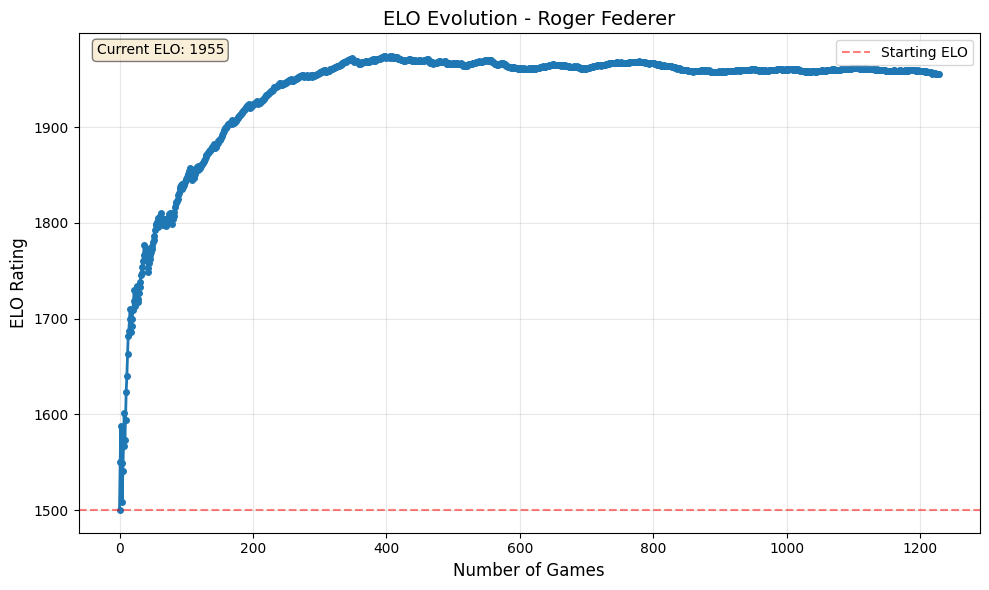

In [256]:
get_player_id(all_data, "Roger Federer")
plot_elo_evolution([i['Ovr'] for i in elo_dict[get_player_id(all_data, "Roger Federer")]], "Roger Federer")

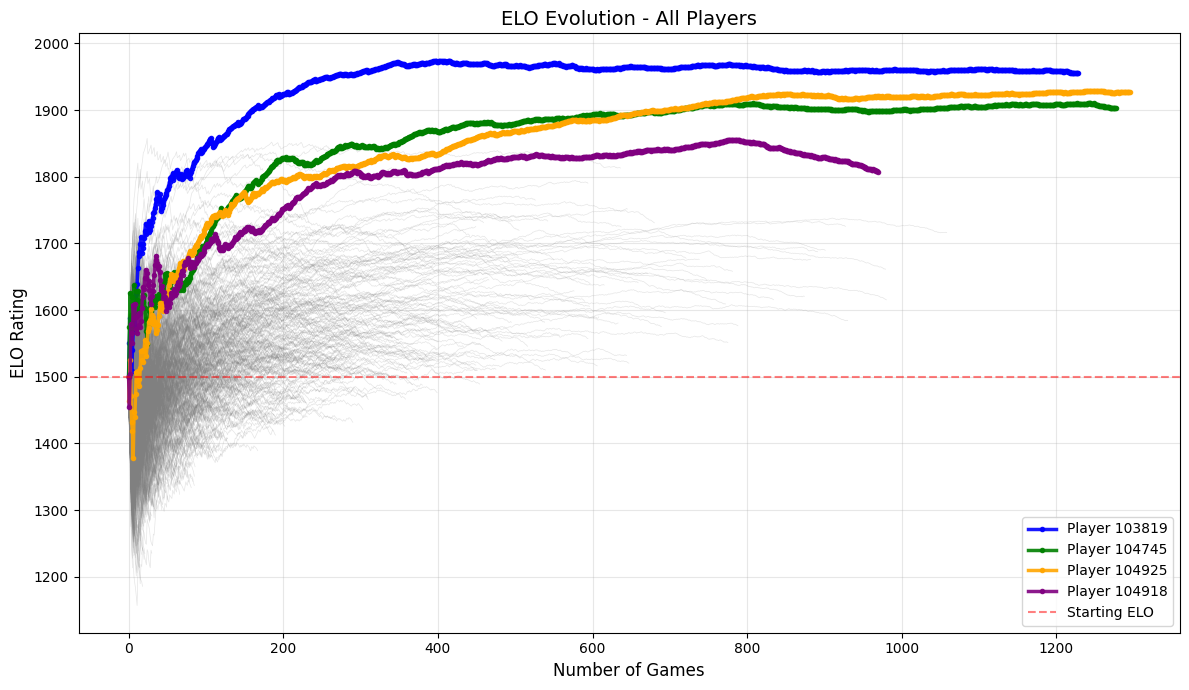

In [257]:
plot_multiple_elos(elo_dict, [get_player_id(all_data, name) for name in ["Roger Federer", "Rafael Nadal", "Novak Djokovic", "Andy Murray"]])

Best current players

In [258]:
top_10 = sorted(elo_dict.items(), key=lambda x: x[1][-1]['Ovr'], reverse=True)[:10]

# Print them
for rank, (player_id, elo_list) in enumerate(top_10, 1):
    print(f"{rank}. {get_player_name(all_data, player_id)}: {elo_list[-1]['Ovr']:.0f}")

1. Roger Federer: 1955
2. Novak Djokovic: 1927
3. Rafael Nadal: 1902
4. Carlos Alcaraz: 1839
5. Jannik Sinner: 1813
6. Andy Roddick: 1813
7. Andre Agassi: 1809
8. Andy Murray: 1808
9. Juan Martin del Potro: 1790
10. Daniil Medvedev: 1765


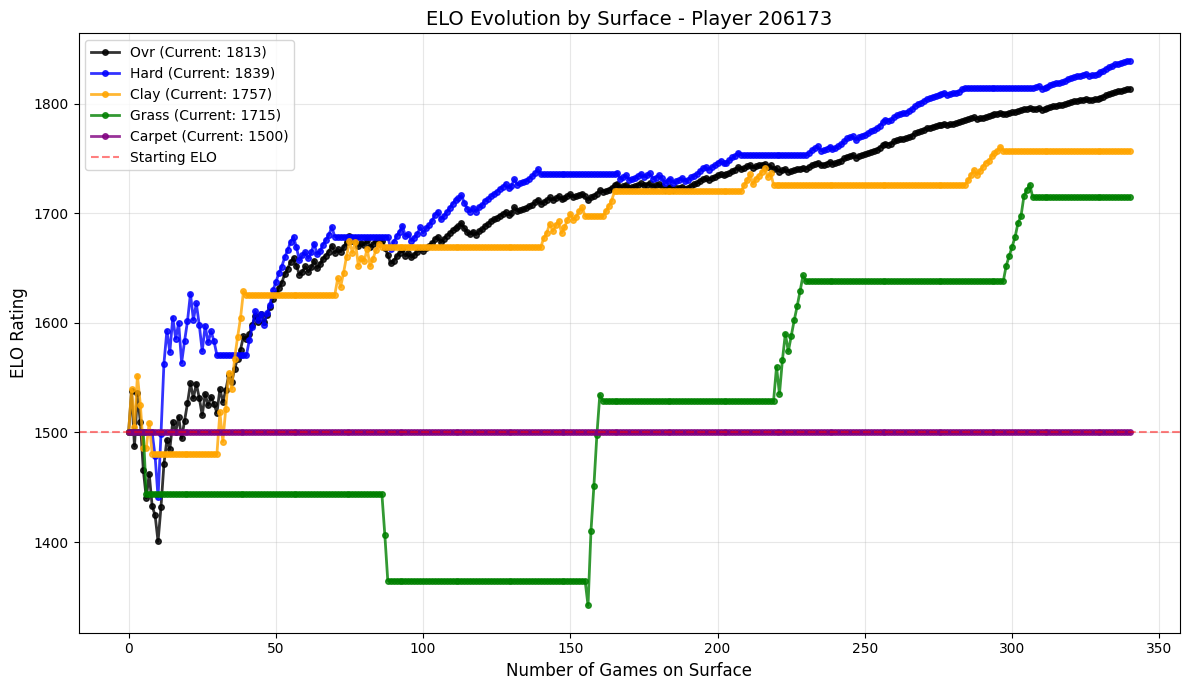

In [259]:
plot_surface_elo_evolution(elo_dict, get_player_id(all_data, "Jannik Sinner"))

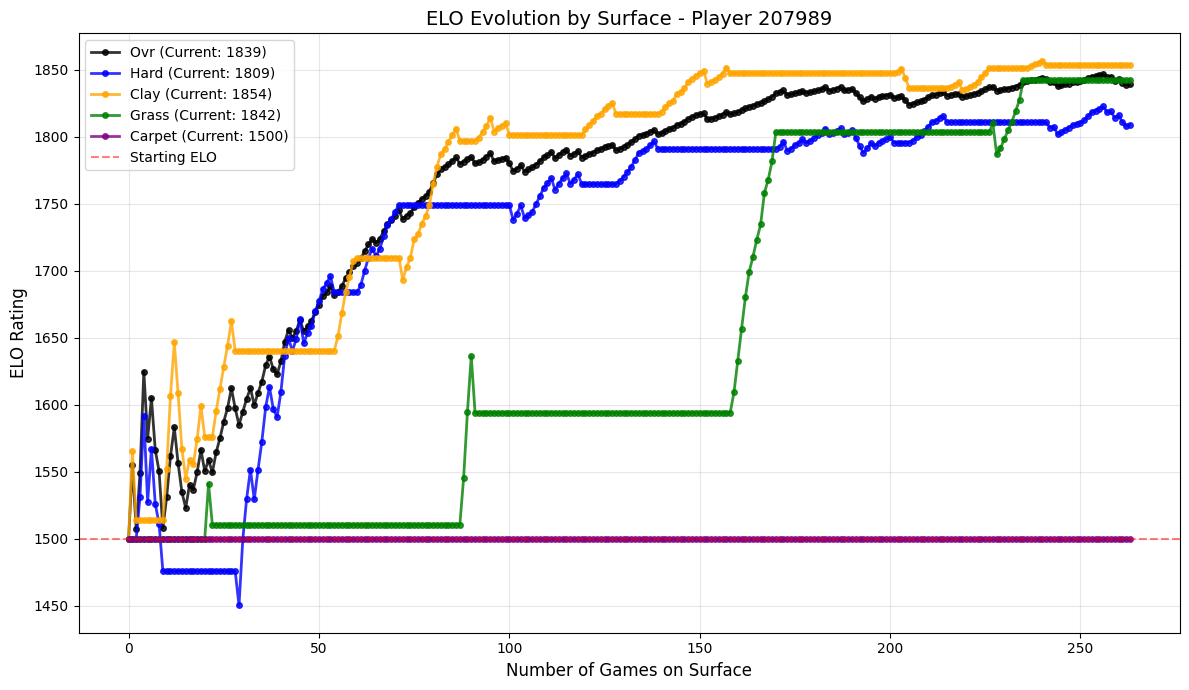

In [260]:
plot_surface_elo_evolution(elo_dict, get_player_id(all_data, "Carlos Alcaraz"))

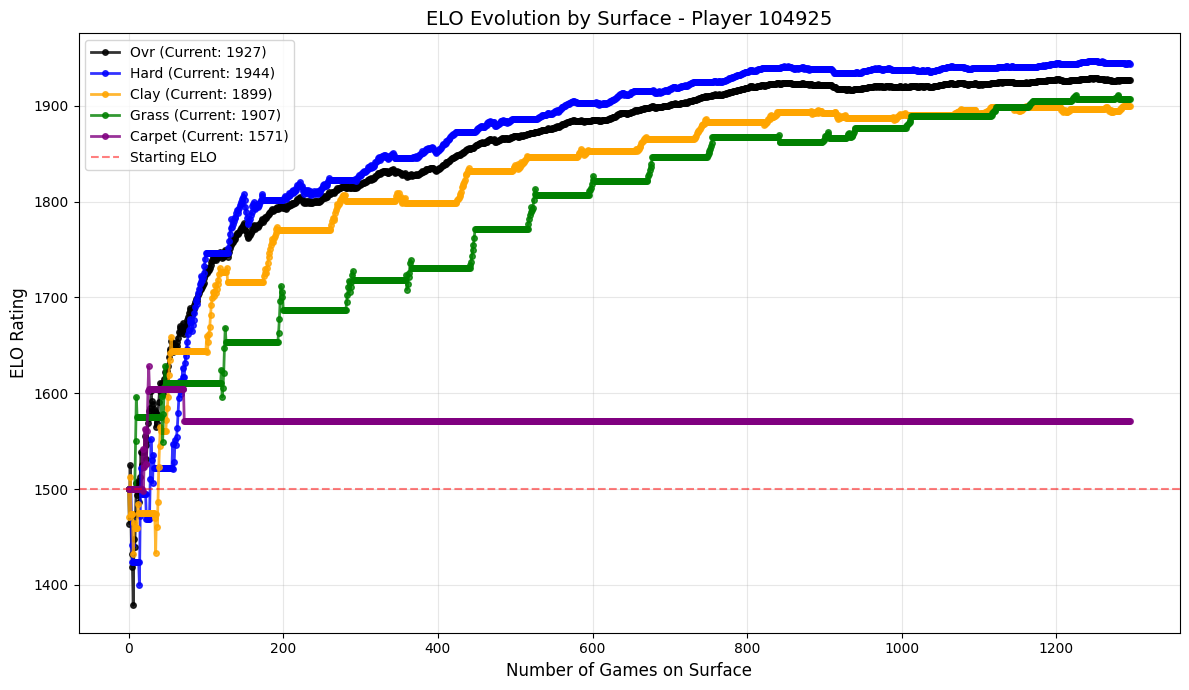

In [261]:
plot_surface_elo_evolution(elo_dict, get_player_id(all_data, "Novak Djokovic"))

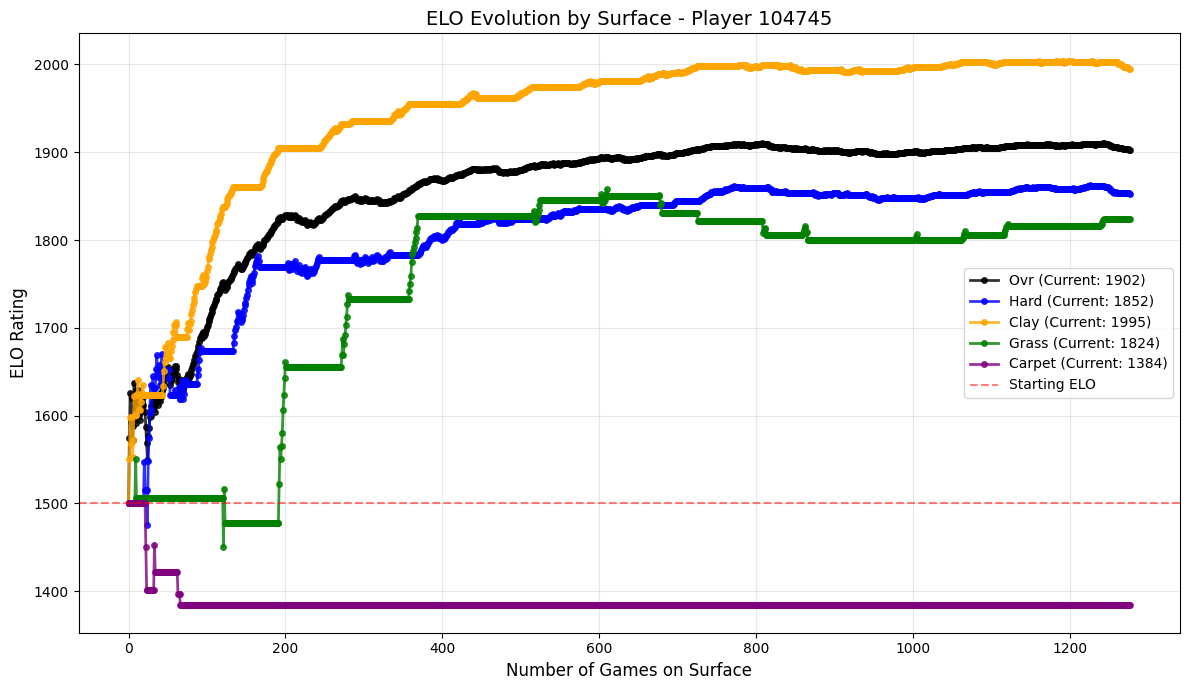

In [262]:
plot_surface_elo_evolution(elo_dict, get_player_id(all_data, "Rafael Nadal"))

# ELO ALONE ACCURACY

In [263]:
acc=train_df[train_df['Elo_Surface_Diff']>0]['result'].value_counts()
float(acc[1]/(acc[1]+acc[0]))

0.6452769066409346

In [264]:
acc=train_df[train_df['Elo_Diff']>0]['result'].value_counts()
float(acc[1]/(acc[1]+acc[0]))

0.6460584165502198

In [265]:
for col in train_df.columns[:-1]:
        acc=train_df[train_df[col]>0]['result'].value_counts()
        print(f"{col}: {float(acc[1]/(acc[1]+acc[0])):.4f}")

draw_size: 0.5013
best_of: 0.5013
ATP_Point_Diff: 0.6541
Rank_Diff: 0.3488
Height_Diff: 0.5325
Age_Diff: 0.4862
H2H_Diff: 0.6203
H2H_Surface_Diff: 0.6268
N_Games_Diff: 0.6125
Win_Rate_3_Diff: 0.6051
Win_Rate_5_Diff: 0.6280
Win_Rate_10_Diff: 0.6429
Win_Rate_25_Diff: 0.6521
Win_Rate_50_Diff: 0.6541
Win_Rate_100_Diff: 0.6514
Elo_Diff: 0.6461
Elo_Surface_Diff: 0.6453
Elo_Grad_5_Diff: 0.5061
Elo_Grad_10_Diff: 0.5336
Elo_Grad_20_Diff: 0.5420
Elo_Grad_35_Diff: 0.5424
Elo_Grad_50_Diff: 0.5437
Elo_Grad_100_Diff: 0.5435
Elo_Grad_250_Diff: 0.5384
p_ace_diff_last_3: 0.5463
p_df_diff_last_3: 0.4789
p_1stIn_diff_last_3: 0.5256
p_1stWon_diff_last_3: 0.5680
p_2ndWon_diff_last_3: 0.5253
p_bpSaved_diff_last_3: 0.5268
p_bpConv_diff_last_3: 0.5182
p_rpw_diff_last_3: 0.5492
p_acedAgainst_diff_last_3: 0.4854
p_totalPtsWon_diff_last_3: 0.5875
p_dominanceRatio_diff_last_3: 0.5891
p_ace_diff_last_5: 0.5493
p_df_diff_last_5: 0.4763
p_1stIn_diff_last_5: 0.5282
p_1stWon_diff_last_5: 0.5779
p_2ndWon_diff_last_5: 0